### Where does the dataset come from? Download from yelp.com

### Businesses

In [3]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = []

with open('yelp_dataset/yelp_academic_dataset_business.json') as f:

    for line in f:
        
        json_dict = json.loads(line)

        if json_dict['attributes']:
            if 'BusinessParking' in json_dict['attributes'].keys():

                json_dict['attributes']['BusinessParking'] = eval(json_dict['attributes']['BusinessParking'])

        data.append(json_dict)

In [5]:
businesses = pd.json_normalize(data)

In [6]:
businesses.columns = businesses.columns.str.split(('.')).str[-1]

In [7]:
columns = []

for column in businesses.columns:
    column = re.sub(r'(\w)([A-Z])', r'\1_\2', column)
    column = re.sub(r'Restaurants_', r'', column)
    column = re.sub(r'Business_', r'', column)
    column = re.sub(r'(Range)([0-9])', r'\1', column)
    columns.append(column.lower())

businesses.columns = columns

In [8]:
# Explain why some columns are dropped (because there are too many missing values!)

businesses.drop(
  [
    'attributes',
    'hair_specializes_in',
    'counter_service',
    'open24_hours',
    'dietary_restrictions',
    'accepts_insurance',
    'ages_allowed',
    'b_yo_bcorkage',
    'corkage',
    'smoking',
    'b_yo_b',
    'good_for_dancing',
    'coat_check',
    'by_appointment_only',
    'best_nights',
    'music',
    'drive_thru',
    'accepts_bitcoin',
    'dogs_allowed',
    'happy_hour',
    'wheelchair_accessible',
    'good_for_meal',
    'ambience',
    'business_parking',
    'address',
    'postal_code',
    'hours',
    'is_open',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    'sunday'
  ],
  axis=1, errors='ignore', inplace=True)

In [9]:
businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']] = businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']].apply(lambda x: x.str.strip("u'"), axis=0)

In [10]:
def check_parking(row):
    if True in row.values:
        return True
    elif False in row.values:
        return False
    else:
        return np.nan

In [11]:
businesses['parking'] = businesses[['garage', 'street', 'validated', 'lot', 'valet']].apply(check_parking, axis=1)

In [12]:
businesses.drop(['garage', 'street','validated','lot','valet'], axis=1, inplace=True)

### We have created a table with all businesses and the attributes we want to have a look at

### Businesses in Pennsylvania

In [13]:
pennsylvania = businesses[businesses['state'] == 'PA'].copy()

### Restaurants in Pennsylvania

In [14]:
pennsylvania.dropna(subset='categories', inplace=True)
pennsylvania.reset_index(drop=True, inplace=True)

In [16]:
categories ={
    'Coffee & Tea',
    'Bistros',
    'Breakfast & Brunch',
    'Cafes',
    'French',
    'Greek',
    'Italian',
    'Mexican',
    'Tacos',
    'Egyptian',
    'Pizza',
    'Soup',
    'Sushi Bars',
    'Vegetarian',
    'Waffles',
    'Food',
    'Restaurants',
    'Bars'
}

def check_categories(row):
    if set(row.split(', ')).intersection(categories):
        return True

In [17]:
restaurants = pennsylvania[pennsylvania['categories'].apply(check_categories) == True]

In [18]:
restaurants.reset_index(drop=True, inplace=True)

In [19]:
restaurants

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,accepts_credit_cards,...,outdoor_seating,has_tv,reservations,alcohol,good_for_kids,parking,attire,table_service,good_for_groups,noise_level
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",False,...,False,NaN,NaN,none,NaN,True,NaN,NaN,NaN,NaN
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,"Brewpubs, Breweries, Food",True,...,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,PA,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",True,...,True,False,True,full_bar,False,True,casual,True,True,average
3,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,PA,39.943223,-75.162568,4.5,205,"Korean, Restaurants",True,...,None,True,False,none,True,True,casual,True,False,quiet
4,QdN72BWoyFypdGJhhI5r7g,Bar One,Philadelphia,PA,39.939825,-75.157447,4.0,65,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",True,...,False,True,False,full_bar,False,True,casual,True,True,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15821,gPr1io7ks0Eo3FDsnDTYfg,Tata Cafe,Philadelphia,PA,40.060414,-75.191084,4.0,21,"Sandwiches, Restaurants, Italian",True,...,True,True,False,none,True,False,casual,False,True,quiet
15822,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,Philadelphia,PA,40.032483,-75.214430,3.0,55,"Restaurants, Specialty Food, Food, Sandwiches,...",True,...,False,True,False,none,True,True,casual,NaN,False,average
15823,8n93L-ilMAsvwUatarykSg,Kitchen Gia,Philadelphia,PA,39.951018,-75.198240,3.0,22,"Coffee & Tea, Food, Sandwiches, American (Trad...",True,...,True,True,False,none,True,False,casual,False,True,average
15824,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,Clifton Heights,PA,39.925656,-75.310344,3.0,11,"Restaurants, Sandwiches, Convenience Stores, C...",True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


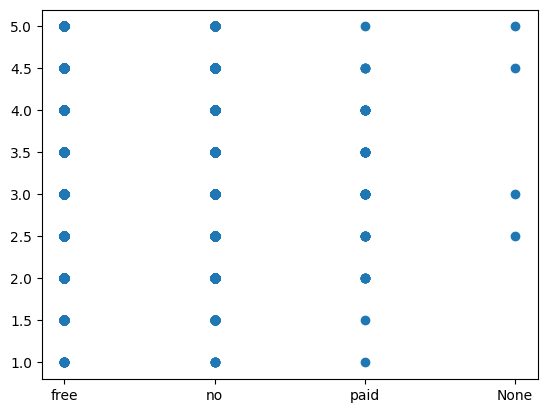

In [20]:
plt.scatter(restaurants['wi_fi'][restaurants['wi_fi'].notna()], restaurants['stars'][restaurants['wi_fi'].notna()])

In [42]:
for label in restaurants.columns[9:]:
    display(pd.crosstab(restaurants[label][restaurants[label].notna()], restaurants['stars'][restaurants[label].notna()], margins=True, normalize='columns'))

stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
accepts_credit_cards,,,,,,,,,,
False,0.025,0.01634,0.019763,0.025585,0.043381,0.054878,0.088107,0.119311,0.126386,0.068411
None,0.000,0.00000,0.001318,0.000000,0.000447,0.000915,0.000000,0.000442,0.000000,0.000418
True,0.975,0.98366,0.978920,0.974415,0.956172,0.944207,0.911893,0.880247,0.873614,0.931171


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
bike_parking,,,,,,,,,,
False,0.571429,0.452632,0.469828,0.358306,0.294937,0.240357,0.203782,0.207365,0.236667,0.257860
None,0.000000,0.010526,0.002155,0.000000,0.002532,0.000406,0.000000,0.001700,0.000000,0.001042
True,0.428571,0.536842,0.528017,0.641694,0.702532,0.759237,0.796218,0.790935,0.763333,0.741098


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
price_range,,,,,,,,,,
1,0.851064,0.800000,0.566138,0.423450,0.373845,0.367105,0.387713,0.467717,0.500000,0.420033
2,0.085106,0.159375,0.388889,0.526512,0.577634,0.568451,0.542328,0.473310,0.453947,0.521017
3,0.042553,0.040625,0.037037,0.044063,0.044362,0.059634,0.062022,0.050839,0.039474,0.052690
4,0.021277,0.000000,0.006614,0.005975,0.004159,0.004489,0.007643,0.007626,0.006579,0.005962
None,0.000000,0.000000,0.001323,0.000000,0.000000,0.000321,0.000294,0.000508,0.000000,0.000298


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
take_out,,,,,,,,,,
False,0.109091,0.153355,0.122148,0.093558,0.063433,0.056087,0.056250,0.055531,0.098131,0.067907
None,0.036364,0.015974,0.021477,0.013037,0.027052,0.014022,0.028125,0.029088,0.044393,0.023426
True,0.854545,0.830671,0.856376,0.893405,0.909515,0.929892,0.915625,0.915381,0.857477,0.908666


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
delivery,,,,,,,,,,
False,0.163934,0.117460,0.204871,0.302306,0.332833,0.333785,0.318237,0.348058,0.352785,0.316573
None,0.049180,0.031746,0.030086,0.028007,0.047047,0.041300,0.068085,0.066505,0.074271,0.051901
True,0.786885,0.850794,0.765043,0.669687,0.620120,0.624915,0.613678,0.585437,0.572944,0.631526


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
caters,,,,,,,,,,
False,0.736842,0.744966,0.627204,0.505263,0.401439,0.363311,0.381419,0.381430,0.368,0.406742
None,0.000000,0.000000,0.000000,0.002632,0.000000,0.002685,0.001568,0.000627,0.000,0.001391
True,0.263158,0.255034,0.372796,0.492105,0.598561,0.634004,0.617013,0.617942,0.632,0.591867


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
wi_fi,,,,,,,,,,
None,0.00,0.000000,0.000000,0.001143,0.000646,0.000000,0.000000,0.000614,0.004202,0.000394
free,0.72,0.603550,0.548387,0.515429,0.505168,0.522303,0.522555,0.565111,0.575630,0.530234
no,0.24,0.390533,0.437788,0.474286,0.483850,0.472830,0.472754,0.431818,0.415966,0.463266
paid,0.04,0.005917,0.013825,0.009143,0.010336,0.004866,0.004691,0.002457,0.004202,0.006106


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
outdoor_seating,,,,,,,,,,
False,0.826087,0.750000,0.744917,0.677694,0.630803,0.581935,0.528926,0.490265,0.535088,0.581273
None,0.000000,0.058824,0.024030,0.020794,0.010923,0.013210,0.034050,0.063127,0.043860,0.028406
True,0.173913,0.191176,0.231054,0.301512,0.358274,0.404855,0.437025,0.446608,0.421053,0.390321


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
has_tv,,,,,,,,,,
False,0.15,0.151163,0.168514,0.183114,0.219988,0.241446,0.303869,0.400645,0.423913,0.271879
None,0.00,0.000000,0.000000,0.000000,0.000591,0.000000,0.000000,0.001290,0.000000,0.000289
True,0.85,0.848837,0.831486,0.816886,0.779420,0.758554,0.696131,0.598065,0.576087,0.727832


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
reservations,,,,,,,,,,
False,0.888889,0.913462,0.783673,0.711155,0.635482,0.560856,0.57410,0.652941,0.701657,0.624193
None,0.000000,0.004808,0.002041,0.007968,0.002282,0.007137,0.00494,0.009150,0.000000,0.005707
True,0.111111,0.081731,0.214286,0.280876,0.362236,0.432006,0.42096,0.337908,0.298343,0.370100


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
alcohol,,,,,,,,,,
None,0.000000,0.000000,0.000000,0.001101,0.000591,0.000000,0.001069,0.001311,0.005236,0.000773
beer_and_wine,0.000000,0.006667,0.024499,0.033040,0.039575,0.046708,0.053100,0.051803,0.015707,0.044616
full_bar,0.095238,0.080000,0.247216,0.350220,0.376255,0.366003,0.292231,0.160000,0.068063,0.300628
none,0.904762,0.913333,0.728285,0.615639,0.583579,0.587289,0.653599,0.786885,0.910995,0.653984


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
good_for_kids,,,,,,,,,,
False,0.423077,0.233831,0.206122,0.171079,0.197654,0.191365,0.207611,0.154244,0.145038,0.191300
None,0.000000,0.000000,0.000000,0.001018,0.000587,0.001167,0.000377,0.000738,0.000000,0.000692
True,0.576923,0.766169,0.793878,0.827902,0.801760,0.807468,0.792012,0.845018,0.854962,0.808008


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
parking,,,,,,,,,,
False,0.625,0.480916,0.45389,0.337043,0.267104,0.20025,0.189129,0.200983,0.357143,0.244001
True,0.375,0.519084,0.54611,0.662957,0.732896,0.79975,0.810871,0.799017,0.642857,0.755999


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
attire,,,,,,,,,,
None,0.000000,0.000000,0.000000,0.000000,0.000609,0.000000,0.000795,0.000000,0.000000,0.000315
casual,0.944444,0.989474,0.986842,0.981953,0.979915,0.970180,0.974553,0.978495,0.980198,0.976476
dressy,0.055556,0.000000,0.008772,0.015924,0.017042,0.028186,0.023459,0.020678,0.019802,0.021319
formal,0.000000,0.010526,0.004386,0.002123,0.002435,0.001634,0.001193,0.000827,0.000000,0.001890


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
table_service,,,,,,,,,,
False,0.857143,0.763158,0.603774,0.473469,0.381308,0.286706,0.319269,0.389760,0.584,0.361918
None,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001045,0.000,0.000225
True,0.142857,0.236842,0.396226,0.526531,0.618692,0.713294,0.680731,0.609195,0.416,0.637857


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
good_for_groups,,,,,,,,,,
False,0.407407,0.311881,0.248016,0.197628,0.151429,0.137747,0.169928,0.235380,0.282443,0.178578
None,0.000000,0.000000,0.000000,0.000000,0.000571,0.000761,0.000362,0.000731,0.000000,0.000482
True,0.592593,0.688119,0.751984,0.802372,0.848000,0.861492,0.829710,0.763889,0.717557,0.820940


stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
noise_level,,,,,,,,,,
None,0.0625,0.000000,0.005464,0.000000,0.001330,0.000868,0.001621,0.000000,0.000000,0.001232
average,0.3750,0.500000,0.551913,0.623153,0.649601,0.695011,0.721119,0.701131,0.488889,0.677571
loud,0.2500,0.156250,0.114754,0.129310,0.091090,0.074187,0.063640,0.036349,0.011111,0.076406
quiet,0.1250,0.195312,0.204918,0.173645,0.212766,0.204772,0.200243,0.251212,0.500000,0.211181
very_loud,0.1875,0.148438,0.122951,0.073892,0.045213,0.025163,0.013377,0.011309,0.000000,0.033610


In [17]:
with open('tables/restaurants_pennsylvania.csv', 'w') as f:
    restaurants.to_csv(f, header=True, index=False)

### We have created a table with all restaurants in Pennsylvania and saved it in a .csv for later analysis

### Now we load the table with all reviews and create a .csv which only contains reviews from restaurants in Pennsylvania

In [ ]:
businesses_ids = restaurants['business_id'].to_list()

column_names = ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

chunks = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

with open('tables/reviews_pennsylvania.csv', 'w') as f:
    header = ','.join(column_names)
    f.write(header + '\n')

    for chunk in chunks:
        reviews = pd.DataFrame(chunk)
        
        reviews[reviews['business_id'].isin(businesses_ids)].to_csv(f, mode='a', header=False, index=False)

### Analysis starts here

In [ ]:
restaurants = get_file('tables/restaurants_pennsylvania.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))

# fig.suptitle('Customer ratings', fontsize=16)

sns.barplot(
    ax = ax,
    x=restaurants['stars'].value_counts().sort_index().index,
    y=restaurants['stars'].value_counts().sort_index().values*100/restaurants['stars'].value_counts().sort_index().values.sum(),
    color='#FF1A1A'
)
ax.set(xlabel='Stars', ylabel='No. of businesses in %')
ax.set_title('Star ratings');

In [ ]:
restaurants[[
    'stars',
    'accepts_credit_cards',
    'bike_parking',
    'price_range',
    'take_out',
    'delivery',
    'caters',
    'wi_fi',
    'outdoor_seating',
    'has_tv',
    'reservations',
    'alcohol',
    'good_for_kids',
    'attire',
    'table_service',
    'good_for_groups',
    'noise_level',
    'parking_available'
]].corr(method='spearman')

In [ ]:
reviews = get_file('tables/reviews_pennsylvania.csv')

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')

def check_polarity(text):
    doc = nlp(text)
    return doc._.blob.polarity

reviews['polarity'] = reviews['text'][:10000].apply(lambda x: check_polarity(x))

In [ ]:
with open('tables/reviews_polarity.csv', 'w') as f:
    reviews[:10000].to_csv(f, header=True, index=False)

In [ ]:
reviews = get_file('tables/reviews_polarity.csv')

In [ ]:
negative_reviews = reviews[reviews['polarity'] < 0]

### Analys negative reviews

#### We want to find statements about food

In [72]:
# Training the entity rule to recognize food

food = pd.read_csv('food_labels/food.csv')

In [89]:
food_labels = food[food['description'].str.contains('[a-zA-Z]') == True]['description']

In [90]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [91]:
food_labels = food_labels.str.lower()

In [92]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [93]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [94]:
# If label has no plural, create singular form. If label has no singular, create plural 

import spacy
import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [99]:
food_labels_inflected = pd.Series(inflected_labels)

In [100]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [101]:
food_labels.drop_duplicates(inplace=True)

In [102]:
food_labels[food_labels.str.contains('bar', regex=True)]

2645        italian barley
3702        barbecue spice
5431               bar bar
5547            fudge bars
7690         sweet bar-b-q
               ...        
15881          chunky bars
16540           limon bars
16663         hazelnut bar
16778    blueberry golbars
17113             paleobar
Length: 538, dtype: object

In [103]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [104]:
len(patterns)

30704

In [106]:
ruler.to_disk('food_labels/food_patterns.jsonl')

In [ ]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", before='ner')

ruler.from_disk('food_labels/food_patterns.jsonl')